In [1]:
# 先不取平均 看一看能否说明问题
import numpy as np
import sys
sys.path.append(r'C:\Users\zhang\1_jupyter_code\1_Functions')
import matplotlib.pyplot as plt
from cal_ppp_dis import cal_ppp_distance as cal_dis

In [10]:
# 读取xyz数据
file_path = r'C:\Users\zhang\Desktop\md\2024corning\18k\ti-cry_1000p_out.xyz'
ana_frame = 33
###########

# 要分析的元素
ana_element = ['Si','O','Al','Ti']
# 画出分布的元素
draw_element = ['O']
set_cutoff = 4.0

In [11]:
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)

    return frames

# 使用之前的frames列表
frames = read_xyz_frames(file_path)

# 找出最大的x、y和z值
max_x = max([max(frame["atoms"], key=lambda atom: atom["x"])["x"] for frame in frames])
max_y = max([max(frame["atoms"], key=lambda atom: atom["y"])["y"] for frame in frames])
max_z = max([max(frame["atoms"], key=lambda atom: atom["z"])["z"] for frame in frames])

print("Maximum X value:", max_x)
print("Maximum Y value:", max_y)
print("Maximum Z value:", max_z)


Maximum X value: 105.883938
Maximum Y value: 55.101836
Maximum Z value: 11.46299


In [12]:
box_size_old = [max_x+0.01,max_y+0.01,max_z+0.01]
print(box_size_old)
print(frames[0]['atoms'][0])

[105.893938, 55.111836, 11.47299]
{'element': 'O', 'x': 91.304817, 'y': 42.508133, 'z': 2.6712}


In [13]:
data_list = []
for i in frames[ana_frame]['atoms']:
    data_list.append([i['element'],i['x'],i['y'],i['z']])

# 使用pyscal计算 angular parameter

In [14]:
from pyscal3 import System
from pyscal3 import Atoms

In [15]:
sys = System()
sys.box = [[max_x+0.01,0,0],[0,max_y+0.01,0],[0,0,max_z+0.01]]
print(sys.box)

[[105.893938, 0, 0], [0, 55.111836, 0], [0, 0, 11.47299]]


In [16]:
# 将list转为字典 取出我们要分析的元素 
ana_atom_list = []
atom_xyz = []
for i in data_list:
    if i[0] in ana_element:
        atom_xyz.append(i[1:])
        ana_atom_list.append(i)
print(np.array(atom_xyz).shape)

(4315, 3)


In [17]:
# 转换元素格式
adict = {"positions": np.array(atom_xyz, dtype=object)}
atoms = Atoms(adict)
#print(atoms.species)
#print(atoms.positions)
# 实例化
sys.atoms = atoms

In [18]:
# adaptive 
sys.find.neighbors(method='cutoff', cutoff='adaptive')

D:\python_install\lib\site-packages\pyscal3\atoms.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dict.__setitem__(self, key, np.array(val))


In [19]:
sys.calculate.angular_criteria()

In [20]:
sys.atoms.angular_parameters.diamond_angle[1]

3.8553445434472042

In [21]:
len(sys.atoms.angular_parameters.diamond_angle)

4315

# 取出数据并画图

draw_element = [ 'Al']

In [22]:
results_xyz_diamond = []
for i,i_atom in enumerate(ana_atom_list):
    if i_atom[0] in draw_element:
        results_xyz_diamond.append([i_atom[1],i_atom[2],i_atom[3], sys.atoms.angular_parameters.diamond_angle[i]])
print(results_xyz_diamond[0])

[78.573058, 35.94424, 1.30476, 3.6196080471134966]


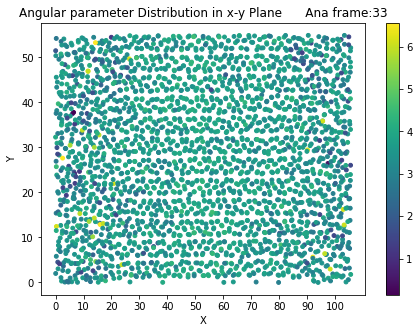

In [23]:
import numpy as np
import matplotlib.pyplot as plt
data_temp = results_xyz_diamond

# 从 data_list 中提取 x、y、q4 和 q6 数据
x_data = [item[0] for item in data_temp]
y_data = [item[1] for item in data_temp]
q4_data = [item[3] for item in data_temp]

# 创建二维分布图
plt.figure(figsize=(16, 5))

# 绘制 q4 在 x-y 平面上的二维分布图
plt.subplot(1, 2, 1)
plt.scatter(x_data, y_data,s=15,c=q4_data, cmap='viridis', marker='o')
plt.colorbar()
plt.title('Angular parameter Distribution in x-y Plane'+  '      Ana frame:'+str(ana_frame) ) ## +'  Ana frame:'+str(ana_frame)
plt.xlabel('X')
plt.ylabel('Y')
# Set the minimum x-axis tick to 10
plt.xticks(range(0, int(max(x_data)) + 1, 10))
# # 绘制 q6 在 x-y 平面上的二维分布图
# plt.subplot(1, 2, 2)
# plt.scatter(x_data, y_data, s=15,c=q6_data, cmap='viridis', marker='o')
# plt.colorbar()
# plt.title('Q6 Distribution in x-y Plane') # +' Ana frame:'+str(ana_frame)
# plt.xlabel('X')
# plt.ylabel('Y')

# # 调整布局
# plt.tight_layout()

# 显示图形
plt.show()
